In [1]:
import keras
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from scipy.stats import percentileofscore, rankdata
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle as pkl
from functools import partial
from tqdm import tqdm_notebook

sns.set_style("darkgrid")
%matplotlib inline

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DATA_PATH = "../Cardiac_muscle/"
MARKS = ["H3K4me3", "H3K9me3", "H3K36me3", "H3K27me3", "H3K27ac", "H3K4me1"]
SIZE = "100"
state = 100

## Model

In [7]:
def get_autoencoder(inside, optimizer, loss):
    input_img = Input(shape=(6,))
    encoded = Dense(4, activation=inside)(input_img)
    encoded = Dense(2, activation=inside)(encoded)
    decoded = Dense(4, activation=inside)(encoded)
    decoded = Dense(6, activation='sigmoid')(decoded)
    deep_autoencoder = Model(input_img, decoded)
    deep_autoencoder.compile(optimizer=optimizer, loss=loss) 
    encoder = Model(input_img, encoded)
    return deep_autoencoder, encoder

In [8]:
insides = ["sigmoid", "relu"]
optimizers = ["adadelta", "adam", "nadam", "adamax", "adagrad"]

In [9]:
autoencoder_dict = dict()
for inside in insides:
    for optimizer in optimizers:
        autoencoder_dict[(inside, optimizer)] = get_autoencoder(inside, optimizer, "mse")

In [10]:
autoencoder_dict[("sigmoid", "nadam")][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_72 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


## Dataset

In [58]:
first_chrom = dict()
for mark in MARKS:
    with open("{}{}_100.pkl".format(DATA_PATH, mark), "rb") as mark_file:
        first_chrom[mark] = pkl.load(mark_file)

In [59]:
for mark in first_chrom:
    where_nans = np.isnan(first_chrom[mark])
    first_chrom[mark][where_nans] = 0

In [ ]:
first_chrom_df = pd.DataFrame(first_chrom)
first_chrom_scaled = pd.DataFrame(scale(first_chrom_df), columns=first_chrom_df.columns)

In [9]:
# first_nonzero = first_chrom_df[first_chrom_df.apply(sum, axis=1) != 0]
first_nonzero = pd.read_hdf("../Cardiac_muscle/first_nonzero.hdf")

In [16]:
first_nonzero.to_hdf("../Cardiac_muscle/first_nonzero.hdf", "w")

In [63]:
genes = pd.read_hdf("../Labels/ensembl_CDSs.hdf")
labels_nonzero = genes[first_nonzero.index]
labels_nonzero.index = range(len(labels_nonzero))

In [10]:
first_nonzero.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.032607
99,0.134452,0.071357,0.150166,0.000000,0.178754,0.166953
100,0.409484,0.331994,0.257893,0.010391,0.527132,0.828330
101,1.106421,0.888328,0.233954,0.135092,0.825033,2.003630
102,1.508669,1.465509,0.462926,0.490447,1.117832,2.107487


In [11]:
len(first_nonzero)

2206482

In [12]:
def get_quant(column, row):
    return percentileofscore(first_chrom_scaled[column], row[column])

In [13]:
quant_scaled = pd.DataFrame()
for column in tqdm_notebook(first_nonzero.columns):
    print(column)
    quant_scaled[column] = rankdata(first_nonzero[column], method="average") / len(first_nonzero)
#     quantilize = partial(get_quant, column)
#     quant_scaled[column] = first_chrom_scaled.apply(quantilize, axis=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me3
H3K9me3



In [14]:
x_train, x_test = train_test_split(quant_scaled, test_size=0.2, random_state=state)

In [15]:
x_train.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
1453965,0.571852,0.915979,0.801637,0.313480,0.846220,0.992860
1915671,0.691489,0.829418,0.880634,0.477877,0.550437,0.919766
1660602,0.916550,0.292676,0.737345,0.948688,0.466556,0.816524
470680,0.754725,0.992119,0.422752,0.422723,0.574312,0.613865
442690,0.542691,0.046222,0.934821,0.428091,0.952296,0.609962


## Train dat shit

In [ ]:
dim_dict = dict()
for key, (autoencoder, encoder) in autoencoder_dict.items():
    autoencoder.fit(x_train, x_train,
                    epochs=20,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    dim_dict[key] = zip(*encoder.predict(quant_scaled))

In [24]:
autoencoder_dict[("sigmoid", "nadam")][0].fit(x_train.values, x_train.values,
                                              epochs=100,
                                              batch_size=256,
                                              shuffle=True,
                                              validation_data=(x_test, x_test))

Train on 1765185 samples, validate on 441297 samples
Epoch 1/100
1765185/1765185 [==============================] - 9s 5us/step - loss: 0.0457 - val_loss: 0.0384
Epoch 2/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0383 - val_loss: 0.0381
Epoch 3/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0382 - val_loss: 0.0381
Epoch 4/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 5/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 6/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0380 - val_loss: 0.0379
Epoch 7/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0376 - val_loss: 0.0369
Epoch 8/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0363 - val_loss: 0.0359
Epoch 9/100
1765185/1765185 [==============================] - 8s 5us/step 

1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 76/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0341
Epoch 77/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 78/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 79/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 80/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 81/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 82/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 83/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 84/100
1765185/17

In [25]:
x, y = zip(*autoencoder_dict[("sigmoid", "nadam")][1].predict(quant_scaled))

In [29]:
auto_df = pd.DataFrame({"x": x, "y": y})

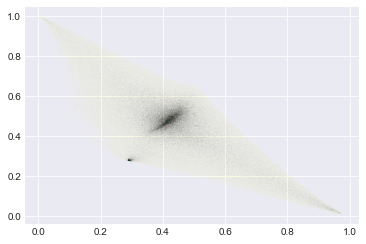

In [38]:
plt.scatter(x, y, alpha=0.007, s=0.1, c=labels_nonzero, cmap="YlGn")

## PCA stuff

In [28]:
pca = PCA(n_components=2)

In [34]:
auto_pca_arr = pca.fit_transform(auto_df)
auto_pca_df = pd.DataFrame(auto_pca_arr, columns=["x", "y"])

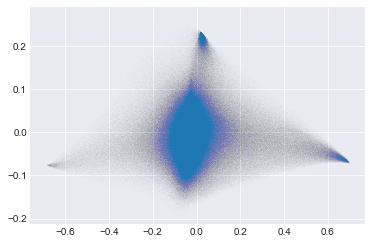

In [35]:
plt.scatter(auto_pca_df["x"], auto_pca_df["y"], alpha=0.007, s=0.1)

## TSNE stuff

In [61]:
x, y = dim_dict[("sigmoid", "nadam")]

In [84]:
first_nonzero["auto_x"] = x
first_nonzero["auto_y"] = y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_nonzero.columns)

In [88]:
first_nonzero_scaled.to_hdf("../Models/first_nonzero_scaled.hdf", key="w")

In [89]:
def lol_sum(row):
    return sum(row[:-2])

In [47]:
first_nonzero = first_chrom_df[first_chrom_df.apply(lol_sum, axis=1) != 0]
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_chrom_df.columns)

In [39]:
little_all_scaled = first_scaled_all.sample(n=6000, random_state=state)

In [98]:
little_nonzero_scaled = first_nonzero_scaled.sample(n=6000, random_state=state)

In [99]:
tsne = TSNE(random_state=state)

In [100]:
lol_table = tsne.fit_transform(little_nonzero_scaled)

In [101]:
lol_x, lol_y = zip(*lol_table)

In [ ]:
plt.scatter(x, y, alpha=1)

In [45]:
first_chrom_df.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
labels_nonzero[labels_nonzero == 0] = -1

In [54]:
sum(labels_nonzero) / len(labels_nonzero)

-0.9192660533827152

In [ ]:
plt.scatter(x, y, alpha=0.1, s=0.2, c=labels_nonzero, cmap="binary")

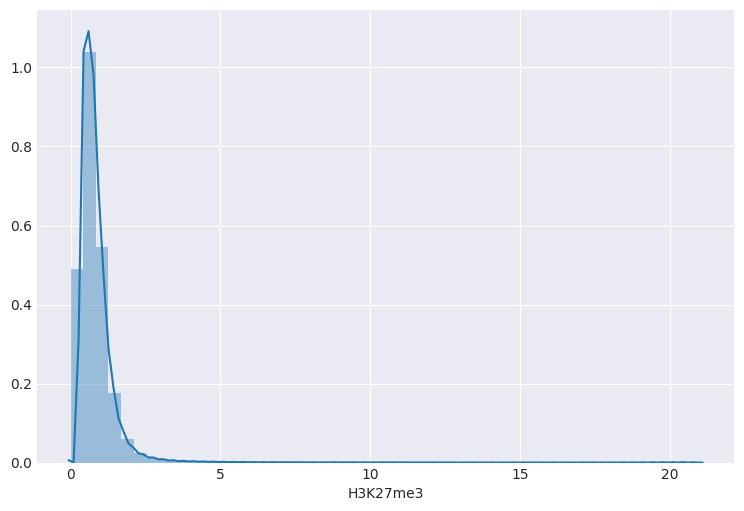

In [104]:
sns.distplot(first_nonzero["H3K27me3"])

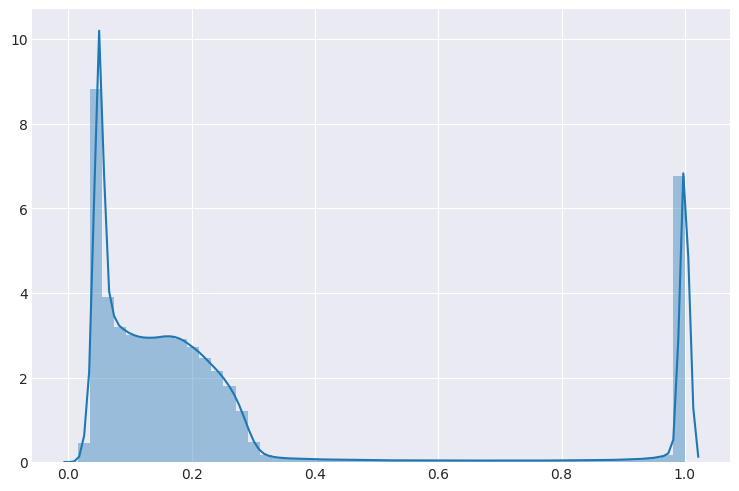

In [67]:
sns.distplot(x)

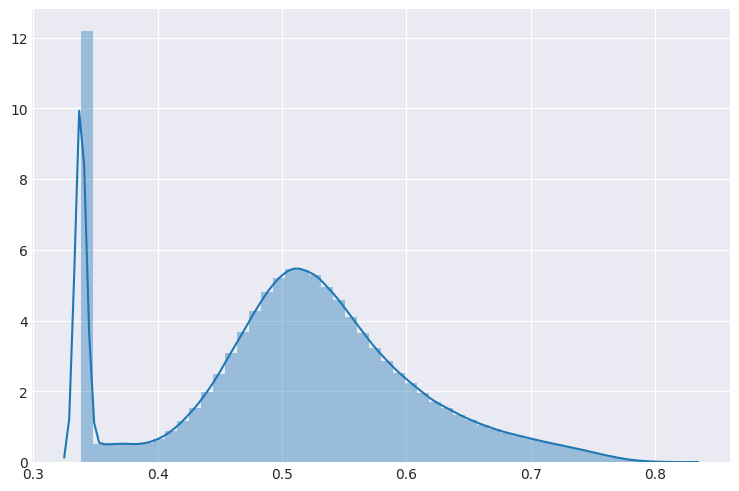

In [68]:
sns.distplot(y)

# DEEEEEEEC

In [7]:
from scipy import optimize
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from sklearn.cluster import KMeans

import pickle as pkl
from random import seed
from itertools import product

In [8]:
from keras.optimizers import SGD
from keras.layers import Input, Dense, LocallyConnected2D
from keras.models import Model, Sequential
import keras.backend as K
import tensorflow as tf

In [6]:
seed(state)

In [13]:
inp = Input(shape=(8,))
encoded = Dense(4)(inp)
decoded = Dense(8)(encoded)
model = Model(inp, decoded)
model.compile(optimizer="nadam", loss="mse")

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
Total params: 76.0
Trainable params: 76.0
Non-trainable params: 0.0
_________________________________________________________________


In [207]:
with open("../Models/dec.pkl", "wb") as dec_file:
    pkl.dump(dec, dec_file)

TypeError: can't pickle _thread.lock objects

In [208]:
stacked_ae = Sequential()
for enc_layer in dec.enc_list:
    stacked_ae.add(enc_layer)
for dec_layer in reversed(dec.dec_list):
    stacked_ae.add(dec_layer)

In [211]:
stacked_ae.compile(optimizer="nadam", loss="mse")

In [212]:
stacked_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 5)                 35        
_________________________________________________________________
dense_147 (Dense)            (None, 4)                 24        
_________________________________________________________________
dense_148 (Dense)            (None, 3)                 15        
_________________________________________________________________
dense_149 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_153 (Dense)            (None, 3)                 9         
_________________________________________________________________
dense_152 (Dense)            (None, 4)                 16        
_________________________________________________________________
dense_151 (Dense)            (None, 5)                 25        
__________

In [213]:
stacked_ae.save("../Models/stacked_ae.hdf5")

In [364]:
tf.Tensor.set_shape?

In [79]:
lol = Input(shape=(10,))
kek = Dense(5, activation="sigmoid")
kek(lol)

<tf.Tensor 'dense_2/Sigmoid:0' shape=(?, 5) dtype=float32>

In [496]:
class DEC():
    
    def __init__(self, train_data, test_data, SAE_code, denoise, optimizer, batch_size, 
                 activation, ae_loss, n_clusters, clusterer):
        self.SAE_code = list(map(int, SAE_code))
        self.train_data = {self.SAE_code[0]: train_data}
        self.test_data = {self.SAE_code[0]: test_data}
        self.denoise = denoise
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.activation = activation
        self.ae_loss = ae_loss
        self.n_clusters = n_clusters
        self.clusterer = clusterer
    
    def init_SAE(self):
        self.enc_list = [Dense(encoded_dim, input_shape=(input_dim,), activation=self.activation)
                    for encoded_dim, input_dim in zip(self.SAE_code[1:], self.SAE_code[:-1])]
        self.dec_list = [Dense(decoded_dim, activation=self.activation) 
                    for decoded_dim in self.SAE_code[:-1]]
        for ind, (enc_layer, dec_layer) in enumerate(zip(self.enc_list, self.dec_list)):
            # autoencode stuff
            next_ind = self.SAE_code[ind + 1]
            ind = self.SAE_code[ind]
            ae = Sequential()
            ae.add(enc_layer)
            ae.add(dec_layer)
            ae.compile(optimizer=self.optimizer, loss=self.ae_loss)
            print(ae.summary())
            ae.fit(self.train_data[ind], self.train_data[ind],
                   batch_size=self.batch_size,
                   epochs=20,
                   shuffle=True,
                   validation_data=(self.test_data[ind], self.test_data[ind]))
            
            # encode stuff
            e = Sequential()
            e.add(enc_layer)
            self.train_data[next_ind] = e.predict(self.train_data[ind])
            self.test_data[next_ind] = e.predict(self.test_data[ind])
    
    def fine_tune_SAE(self):
        # autoencode stuff
        ae = Sequential()
        for enc_layer in self.enc_list:
            ae.add(enc_layer)
        for dec_layer in reversed(self.dec_list):
            ae.add(dec_layer)
        ae.compile(optimizer=self.optimizer, loss="mse")
        ind = self.SAE_code[0]
        ae.fit(self.train_data[ind], self.train_data[ind],
               batch_size=self.batch_size,
               epochs=100,
               shuffle=True,
               validation_data=(self.test_data[ind], self.test_data[ind]))
        self._encode_data()
        
    def _encode_data(self):    
        ind = self.SAE_code[0]
        e = Sequential()
        for enc_layer in self.enc_list:
            e.add(enc_layer)
        self.train_data["final"] = e.predict(self.train_data[ind])
        
    def learn_clustering(self):
        self.clusterer.fit(self.train_data["final"])
        if type(self.clusterer) == HDBSCAN:
            self.n_clusters = len(np.unique(self.clusterer.labels_))
            
        self.centers = self.clusterer.cluster_centers_
        self.plot_initial_clust()
        
        self.train_ones = np.ones(shape=(len(self.train_data[self.SAE_code[0]]), self.n_clusters, 
                                         self.SAE_code[-1], 1))
        self.test_ones = np.ones(shape=(len(self.test_data[self.SAE_code[0]]), self.n_clusters, 
                                         self.SAE_code[-1], 1))
        train_data = self.train_data[self.SAE_code[0]]
        train_ones = self.train_ones 
        test_data = self.test_data[self.SAE_code[0]]
        test_ones = self.test_ones
        
        
        # build model
        input_data_layer = Input(shape=train_data[0].shape, name="data_input")
        input_ones_layer = Input(shape=train_ones[0].shape, name="ones_input")
        pointwise = LocallyConnected2D(1, kernel_size=(1, 1), use_bias=False, name="centers_output") 
#                                        input_shape=(*self.centers.shape, 1))
        pointwise_called = pointwise(input_ones_layer)
        print(pointwise.get_weights())
        pointwise.set_weights(np.reshape(self.centers, (1, np.product(self.centers.shape), 1, 1)))
        
        last = input_data_layer
        for enc_layer in self.enc_list:
            last = enc_layer(last)
            
        model = Model(inputs=[input_data_layer, input_ones_layer], outputs=[last, pointwise_called])
        model.compile(optimizer=self.optimizer, 
                      loss=[self._KL_loss(centers=pointwise_called), self._KL_loss(encoded=last)])
#                           loss_weights=[1., 1.])
        
        model.fit([train_data, train_ones], [np.zeros_like(train_data), np.zeros_like(train_ones)], 
                  batch_size=self.batch_size, 
                  epochs=100, 
                  shuffle=True,
                  validation_data=([test_data, test_ones], [np.zeros_like(test_data), np.zeros_like(test_ones)]))
        self.optimized_encoded = model.predict([train_data, train_ones])
        self.optimized_centers = pointwise.get_weights()
    
    def plot_initial_clust(self):
        x, y = zip(*self.train_data["final"])
        if type(self.clusterer) is not HDBSCAN:
            c_x, c_y = zip(*self.centers)
        
            plt.scatter(x, y, color="blue")
            plt.scatter(c_x, c_y, color="red")
        else:
            plt.scatter(x, y, c=self.clusterer.labels_, cmap="tab10")
        
    def _KL_loss(self, centers=None, encoded=None):
        if (centers is not None) and (encoded is None):
            def KL_loss(encoded_true, encoded_pred):
                q = self._get_q(encoded_pred, centers)
                f = self._get_f(q)
                p = self._get_p(q, f)
                
                loss = tf.reduce_sum(tf.multiply(p, tf.log(tf.div(p, q))))
                return loss
#                 return tf.subtract(tf.zeros_like(loss), loss)
            return KL_loss
            
        elif (encoded is not None) and (centers is None):
            def KL_loss(centers_true, centers_pred):
                q = self._get_q(encoded, centers_pred)
                f = self._get_f(q)
                p = self._get_p(q, f)
    
                loss = tf.reduce_sum(tf.multiply(p, tf.log(tf.div(p, q))))
                return loss
#                 return tf.subtract(tf.zeros_like(loss), loss)
            return KL_loss
            
        else:
            raise Exception("Fuck it!")
            return
    
    def _get_q(self, encoded, centers):
        encoded.set_shape((self.batch_size, self.SAE_code[-1]))
        centers.set_shape((self.batch_size, self.n_clusters, self.SAE_code[-1], 1))
        centers_stacked = tf.squeeze(centers)
        encoded_stacked = tf.stack([encoded for _ in range(self.n_clusters)], axis=1)

        q = tf.subtract(encoded_stacked, centers_stacked)
        q_sqr = tf.multiply(q, q)
        q_normed_sqr = tf.reduce_sum(q_sqr, axis=2)
        
        ones = tf.ones_like(q_normed_sqr)
        numerator = tf.divide(ones, tf.add(ones, q_normed_sqr))
        almost_denominator = tf.reduce_sum(numerator, axis=1)
        denominator = tf.stack([almost_denominator for _ in range(self.n_clusters)], axis=1)

        true_q = tf.divide(numerator, denominator)
        print("Q shape:", true_q.get_shape())
        return true_q
        #---------------------------------------------
            
    def _get_f(self, q):
        f_unstacked = tf.reduce_sum(q, axis=0)
        f = tf.stack([f_unstacked for _ in range(self.batch_size)])
        
       #--------------------------------- 
        return f
    
    def _get_p(self, q, f):
        numerator = tf.divide(tf.multiply(q, q), f)
        almost_denominator = tf.reduce_sum(numerator, axis=1)
        denominator = tf.stack([almost_denominator for _ in range(self.n_clusters)], axis=1)
        p = tf.divide(numerator, denominator)
        #------------------------------------------
        return p
    
    def get_from_layers(self, layers):
        self.enc_list = layers
        self._encode_data()
        

In [457]:
encoder = keras.models.load_model("../Models/stacked_ae.hdf5")

In [458]:
encoder.layers[:4]

## Test loss optimization

In [497]:
n_clusters = 4
clust = KMeans(n_clusters=n_clusters)
# clust = HDBSCAN(min_cluster_size=10)
params = {"train_data": x_train.values[:(len(x_train.values) // 256) * 256], 
          "test_data": x_test.values[:(len(x_test.values) // 256) * 256], 
          "SAE_code": [6, 10, 5, 4, 3, 6, 2], "denoise": False, 
          "optimizer": "nadam", "batch_size": 256, "activation": "sigmoid", "ae_loss": "mse", "n_clusters": n_clusters,
          "clusterer": clust}

In [507]:
ae = Sequential()
e = Sequential()
for enc_layer in dec.enc_list:
    ae.add(enc_layer)
    e.add(enc_layer)
for dec_layer in reversed(dec.dec_list):
    ae.add(dec_layer)
ae.compile(optimizer="nadam", loss="mse")
e.compile(optimizer="nadam", loss="mse")

In [508]:
ae.save("../Models/ae_6-10-5-4-3-6-2.hdf5")
e.save("../Models/e_6-10-5-4-3-6-2.hdf5")

In [498]:
dec = DEC(**params)

In [499]:
# dec.get_from_layers(encoder.layers[:4])
dec.init_SAE()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 10)                70        
_________________________________________________________________
dense_201 (Dense)            (None, 6)                 66        
Total params: 136.0
Trainable params: 136
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1765120 samples, validate on 441088 samples
Epoch 1/20
1765120/1765120 [==============================] - 26s - loss: 0.0070 - val_loss: 0.0011
Epoch 2/20
1765120/1765120 [==============================] - 24s - loss: 9.8034e-04 - val_loss: 9.3296e-04
Epoch 3/20
1765120/1765120 [==============================] - 24s - loss: 9.1220e-04 - val_loss: 8.9581e-04
Epoch 4/20
1765120/1765120 [==============================] - 25s - loss: 8.8826e-04 - val_loss: 8.7906e-04
Epoch 5/20
1765120/1765120 [==========================

1765120/1765120 [==============================] - 25s - loss: 9.7217e-04 - val_loss: 9.7449e-04
Epoch 19/20
1765120/1765120 [==============================] - 27s - loss: 9.7208e-04 - val_loss: 9.7445e-04
Epoch 20/20
1765120/1765120 [==============================] - 24s - loss: 9.7202e-04 - val_loss: 9.7402e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 3)                 15        
_________________________________________________________________
dense_204 (Dense)            (None, 4)                 16        
Total params: 31.0
Trainable params: 31
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1765120 samples, validate on 441088 samples
Epoch 1/20
1765120/1765120 [==============================] - 33s - loss: 0.0031 - val_loss: 9.9713e-04
Epoch 2/20
1765120/1765120 [==============================] -

1765120/1765120 [==============================] - 18s - loss: 8.4499e-04 - val_loss: 8.4333e-04
Epoch 16/20
1765120/1765120 [==============================] - 18s - loss: 8.4497e-04 - val_loss: 8.4363e-04
Epoch 17/20
1765120/1765120 [==============================] - 18s - loss: 8.4494e-04 - val_loss: 8.4318e-04
Epoch 18/20
1765120/1765120 [==============================] - 18s - loss: 8.4494e-04 - val_loss: 8.4318e-04
Epoch 19/20
1765120/1765120 [==============================] - 18s - loss: 8.4488e-04 - val_loss: 8.4362e-04
Epoch 20/20
1765120/1765120 [==============================] - 18s - loss: 8.4493e-04 - val_loss: 8.4339e-04


In [500]:
dec.fine_tune_SAE()

Train on 1765120 samples, validate on 441088 samples
Epoch 1/100
1765120/1765120 [==============================] - 31s - loss: 0.0022 - val_loss: 0.0013
Epoch 2/100
1765120/1765120 [==============================] - 37s - loss: 9.7273e-04 - val_loss: 8.5039e-04
Epoch 3/100
1765120/1765120 [==============================] - 37s - loss: 8.6816e-04 - val_loss: 8.8001e-04
Epoch 4/100
1765120/1765120 [==============================] - 38s - loss: 8.6216e-04 - val_loss: 8.5803e-04
Epoch 5/100
1765120/1765120 [==============================] - 34s - loss: 8.5917e-04 - val_loss: 8.6826e-04
Epoch 6/100
1765120/1765120 [==============================] - 36s - loss: 8.5709e-04 - val_loss: 8.5278e-04
Epoch 7/100
1765120/1765120 [==============================] - 44s - loss: 8.5545e-04 - val_loss: 8.4288e-04
Epoch 8/100
1765120/1765120 [==============================] - 32s - loss: 8.5389e-04 - val_loss: 8.7118e-04
Epoch 9/100
1765120/1765120 [==============================] - 40s - loss: 8.5231e-

1765120/1765120 [==============================] - 26s - loss: 3.0212e-04 - val_loss: 2.8608e-04
Epoch 76/100
1765120/1765120 [==============================] - 24s - loss: 3.0172e-04 - val_loss: 2.8909e-04
Epoch 77/100
1765120/1765120 [==============================] - 24s - loss: 2.9603e-04 - val_loss: 3.0286e-04
Epoch 78/100
1765120/1765120 [==============================] - 24s - loss: 3.2204e-04 - val_loss: 2.8116e-04
Epoch 79/100
1765120/1765120 [==============================] - 31s - loss: 2.9641e-04 - val_loss: 2.7837e-04
Epoch 80/100
1765120/1765120 [==============================] - 26s - loss: 2.9753e-04 - val_loss: 3.4942e-04
Epoch 81/100
1765120/1765120 [==============================] - 27s - loss: 3.1475e-04 - val_loss: 2.8529e-04
Epoch 82/100
1765120/1765120 [==============================] - 25s - loss: 2.9431e-04 - val_loss: 2.9271e-04
Epoch 83/100
1765120/1765120 [==============================] - 32s - loss: 2.9424e-04 - val_loss: 3.0768e-04
Epoch 84/100
1765120/17

[array([[[-0.03921014]],

       [[-0.39691722]],

       [[ 0.16577858]],

       [[ 0.19484514]],

       [[ 0.11862022]],

       [[ 0.22083932]],

       [[ 0.21855366]],

       [[-0.56937253]]], dtype=float32)]
Q shape: (256, 4)
Q shape: (256, 4)
Train on 8192 samples, validate on 2048 samples
Epoch 1/100
8192/8192 [==============================] - 2s - loss: 0.1111 - dense_173_loss: 0.0556 - centers_output_loss: 0.0556 - val_loss: 0.0374 - val_dense_173_loss: 0.0187 - val_centers_output_loss: 0.0187
Epoch 2/100
8192/8192 [==============================] - 0s - loss: 0.0190 - dense_173_loss: 0.0095 - centers_output_loss: 0.0095 - val_loss: 0.0080 - val_dense_173_loss: 0.0040 - val_centers_output_loss: 0.0040
Epoch 3/100
8192/8192 [==============================] - 0s - loss: 0.0041 - dense_173_loss: 0.0020 - centers_output_loss: 0.0020 - val_loss: 0.0016 - val_dense_173_loss: 8.2152e-04 - val_centers_output_loss: 8.2152e-04
Epoch 4/100
8192/8192 [==============================] 

8192/8192 [==============================] - 0s - loss: 7.0669e-06 - dense_173_loss: 3.5335e-06 - centers_output_loss: 3.5335e-06 - val_loss: 8.6896e-06 - val_dense_173_loss: 4.3448e-06 - val_centers_output_loss: 4.3448e-06
Epoch 35/100
8192/8192 [==============================] - 0s - loss: 7.5090e-06 - dense_173_loss: 3.7545e-06 - centers_output_loss: 3.7545e-06 - val_loss: 7.0001e-06 - val_dense_173_loss: 3.5001e-06 - val_centers_output_loss: 3.5001e-06
Epoch 36/100
8192/8192 [==============================] - 0s - loss: 5.2888e-06 - dense_173_loss: 2.6444e-06 - centers_output_loss: 2.6444e-06 - val_loss: 1.1371e-05 - val_dense_173_loss: 5.6857e-06 - val_centers_output_loss: 5.6857e-06
Epoch 37/100
8192/8192 [==============================] - 0s - loss: 6.3550e-06 - dense_173_loss: 3.1775e-06 - centers_output_loss: 3.1775e-06 - val_loss: 8.8430e-06 - val_dense_173_loss: 4.4215e-06 - val_centers_output_loss: 4.4215e-06
Epoch 38/100
8192/8192 [==============================] - 0s - lo

8192/8192 [==============================] - 0s - loss: 5.7477e-06 - dense_173_loss: 2.8738e-06 - centers_output_loss: 2.8738e-06 - val_loss: 3.8445e-06 - val_dense_173_loss: 1.9223e-06 - val_centers_output_loss: 1.9223e-06
Epoch 69/100
8192/8192 [==============================] - 0s - loss: 6.3324e-06 - dense_173_loss: 3.1662e-06 - centers_output_loss: 3.1662e-06 - val_loss: -5.7815e-06 - val_dense_173_loss: -2.8908e-06 - val_centers_output_loss: -2.8908e-06
Epoch 70/100
8192/8192 [==============================] - 0s - loss: 5.1104e-06 - dense_173_loss: 2.5552e-06 - centers_output_loss: 2.5552e-06 - val_loss: 1.2777e-05 - val_dense_173_loss: 6.3887e-06 - val_centers_output_loss: 6.3887e-06
Epoch 71/100
8192/8192 [==============================] - 0s - loss: 6.3841e-06 - dense_173_loss: 3.1920e-06 - centers_output_loss: 3.1920e-06 - val_loss: 9.6322e-06 - val_dense_173_loss: 4.8161e-06 - val_centers_output_loss: 4.8161e-06
Epoch 72/100
8192/8192 [==============================] - 0s -

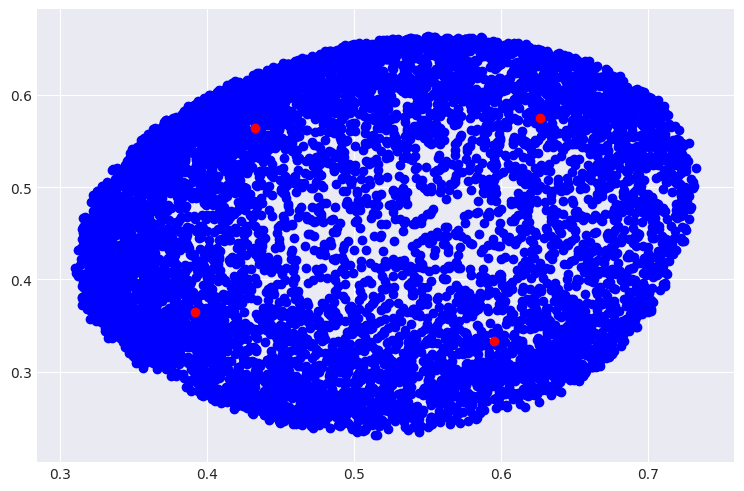

In [488]:
dec.learn_clustering()

In [187]:
dec.optimized_encoded[0]

array([[0.97078055, 0.9647272 ],
       [0.9699219 , 0.96752924],
       [0.02958924, 0.02009389],
       ...,
       [0.9687233 , 0.9690467 ],
       [0.02799802, 0.02217636],
       [0.03017648, 0.02088008]], dtype=float32)

In [501]:
x, y = zip(*dec.train_data["final"])

In [503]:
clust = HDBSCAN(min_cluster_size=1000)

In [505]:
labels = clust.fit_predict(dec.train_data["final"])

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/dist-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fd16ab735d0, file "/...3.6/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/dist-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fd16ab735d0, file "/...3.6/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/dist-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.6/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/explover/.local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/explover/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/explover/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'labels = clust.fit_predict(dec.train_data["final"])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 15, 16, 42, 3, 976981, tzinfo=tzutc()), 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'session': '86EB1B9C24A74FB9A621B1F8D07440A6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'86EB1B9C24A74FB9A621B1F8D07440A6']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'labels = clust.fit_predict(dec.train_data["final"])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 15, 16, 42, 3, 976981, tzinfo=tzutc()), 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'session': '86EB1B9C24A74FB9A621B1F8D07440A6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'86EB1B9C24A74FB9A621B1F8D07440A6'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'labels = clust.fit_predict(dec.train_data["final"])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 15, 16, 42, 3, 976981, tzinfo=tzutc()), 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'session': '86EB1B9C24A74FB9A621B1F8D07440A6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '38D171E807A84BC18D3B0B7FD8DE3F3D', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='labels = clust.fit_predict(dec.train_data["final"])', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'labels = clust.fit_predict(dec.train_data["final"])'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('labels = clust.fit_predict(dec.train_data["final"])',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('labels = clust.fit_predict(dec.train_data["final"])',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='labels = clust.fit_predict(dec.train_data["final"])', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-505-40935c041d43>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fd0b86cd6d8, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fd0be5739c0, file "<ipython-input-505-40935c041d43>", line 1>
        result = <ExecutionResult object at 7fd0b86cd6d8, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fd0be5739c0, file "<ipython-input-505-40935c041d43>", line 1>, result=<ExecutionResult object at 7fd0b86cd6d8, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fd0be5739c0, file "<ipython-input-505-40935c041d43>", line 1>
        self.user_global_ns = {'AffinityPropagation': <class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>, 'DATA_PATH': '../Cardiac_muscle/', 'DEC': <class '__main__.DEC'>, 'Dense': <class 'keras.layers.core.Dense'>, 'HDBSCAN': <class 'hdbscan.hdbscan_.HDBSCAN'>, 'In': ['', "import keras\nimport tensorflow as tf\nfrom keras...._ipython().run_line_magic('matplotlib', 'inline')", 'DATA_PATH = "../Cardiac_muscle/"\nMARKS = ["H3K4m...", "H3K27ac", "H3K4me1"]\nSIZE = "100"\nstate = 100', 'class DEC():\n    \n    def __init__(self, train_d...ist = layers\n        self._encode_data()\n        ', 'encoder = keras.models.load_model("../Models/stacked_ae.hdf5")', 'encoder.layers[:4]', 'clust = KMeans(n_clusters=8)\nparams = {"train_da...", "n_clusters": 8,\n          "clusterer": clust}', 'from scipy import optimize\nimport numpy as np\nim... random import seed\nfrom itertools import product', 'from keras.optimizers import SGD\nfrom keras.laye...import keras.backend as K\nimport tensorflow as tf', '# first_nonzero = first_chrom_df[first_chrom_df....d.read_hdf("../Cardiac_muscle/first_nonzero.hdf")', 'first_nonzero.head()', 'len(first_nonzero)', 'def get_quant(column, row):\n    return percentileofscore(first_chrom_scaled[column], row[column])', 'quant_scaled = pd.DataFrame()\nfor column in tqdm...n] = first_chrom_scaled.apply(quantilize, axis=1)', 'x_train, x_test = train_test_split(quant_scaled, test_size=0.2, random_state=state)', 'x_train.head()', 'class DEC():\n    \n    def __init__(self, train_d...ist = layers\n        self._encode_data()\n        ', 'encoder = keras.models.load_model("../Models/stacked_ae.hdf5")', 'encoder.layers[:4]', 'clust = KMeans(n_clusters=8)\nparams = {"train_da...", "n_clusters": 8,\n          "clusterer": clust}', ...], 'Input': <function Input>, 'K': <module 'keras.backend' from '/home/explover/.lo...Keras-2.0.2-py3.6.egg/keras/backend/__init__.py'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'LocallyConnected2D': <class 'keras.layers.local.LocallyConnected2D'>, ...}
        self.user_ns = {'AffinityPropagation': <class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>, 'DATA_PATH': '../Cardiac_muscle/', 'DEC': <class '__main__.DEC'>, 'Dense': <class 'keras.layers.core.Dense'>, 'HDBSCAN': <class 'hdbscan.hdbscan_.HDBSCAN'>, 'In': ['', "import keras\nimport tensorflow as tf\nfrom keras...._ipython().run_line_magic('matplotlib', 'inline')", 'DATA_PATH = "../Cardiac_muscle/"\nMARKS = ["H3K4m...", "H3K27ac", "H3K4me1"]\nSIZE = "100"\nstate = 100', 'class DEC():\n    \n    def __init__(self, train_d...ist = layers\n        self._encode_data()\n        ', 'encoder = keras.models.load_model("../Models/stacked_ae.hdf5")', 'encoder.layers[:4]', 'clust = KMeans(n_clusters=8)\nparams = {"train_da...", "n_clusters": 8,\n          "clusterer": clust}', 'from scipy import optimize\nimport numpy as np\nim... random import seed\nfrom itertools import product', 'from keras.optimizers import SGD\nfrom keras.laye...import keras.backend as K\nimport tensorflow as tf', '# first_nonzero = first_chrom_df[first_chrom_df....d.read_hdf("../Cardiac_muscle/first_nonzero.hdf")', 'first_nonzero.head()', 'len(first_nonzero)', 'def get_quant(column, row):\n    return percentileofscore(first_chrom_scaled[column], row[column])', 'quant_scaled = pd.DataFrame()\nfor column in tqdm...n] = first_chrom_scaled.apply(quantilize, axis=1)', 'x_train, x_test = train_test_split(quant_scaled, test_size=0.2, random_state=state)', 'x_train.head()', 'class DEC():\n    \n    def __init__(self, train_d...ist = layers\n        self._encode_data()\n        ', 'encoder = keras.models.load_model("../Models/stacked_ae.hdf5")', 'encoder.layers[:4]', 'clust = KMeans(n_clusters=8)\nparams = {"train_da...", "n_clusters": 8,\n          "clusterer": clust}', ...], 'Input': <function Input>, 'K': <module 'keras.backend' from '/home/explover/.lo...Keras-2.0.2-py3.6.egg/keras/backend/__init__.py'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'LocallyConnected2D': <class 'keras.layers.local.LocallyConnected2D'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/explover/Active/ChromatinClustering/repo/<ipython-input-505-40935c041d43> in <module>()
----> 1 labels = clust.fit_predict(dec.train_data["final"])

...........................................................................
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py in fit_predict(self=HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), X=array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32), y=None)
    833         Returns
    834         -------
    835         y : ndarray, shape (n_samples, )
    836             cluster labels
    837         """
--> 838         self.fit(X)
        self.fit = <bound method HDBSCAN.fit of HDBSCAN(algorithm='...samples=None, p=None,
    prediction_data=False)>
        X = array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32)
    839         return self.labels_
    840 
    841     def generate_prediction_data(self):
    842         """

...........................................................................
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py in fit(self=HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), X=array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32), y=None)
    811         (self.labels_,
    812          self.probabilities_,
    813          self.cluster_persistence_,
    814          self._condensed_tree,
    815          self._single_linkage_tree,
--> 816          self._min_spanning_tree) = hdbscan(X, **kwargs)
        self._min_spanning_tree = None
        X = array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32)
        kwargs = {'algorithm': 'best', 'allow_single_cluster': False, 'alpha': 1.0, 'approx_min_span_tree': True, 'cluster_selection_method': 'eom', 'core_dist_n_jobs': 4, 'gen_min_span_tree': False, 'leaf_size': 40, 'match_reference_implementation': False, 'memory': Memory(cachedir=None), ...}
    817 
    818         if self.prediction_data:
    819             self.generate_prediction_data()
    820 

...........................................................................
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py in hdbscan(X=array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32), min_cluster_size=1000, min_samples=1000, alpha=1.0, metric='euclidean', p=None, leaf_size=40, algorithm='best', memory=Memory(cachedir=None), approx_min_span_tree=True, gen_min_span_tree=False, core_dist_n_jobs=4, cluster_selection_method='eom', allow_single_cluster=False, match_reference_implementation=False, **kwargs={})
    538                 (single_linkage_tree, result_min_span_tree) = memory.cache(
    539                     _hdbscan_boruvka_kdtree)(X, min_samples, alpha,
    540                                              metric, p, leaf_size,
    541                                              approx_min_span_tree,
    542                                              gen_min_span_tree,
--> 543                                              core_dist_n_jobs, **kwargs)
        core_dist_n_jobs = 4
        kwargs = {}
    544         else:  # Metric is a valid BallTree metric
    545             # TO DO: Need heuristic to decide when to go to boruvka;
    546             # still debugging for now
    547             if X.shape[1] > 60:

...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _hdbscan_boruvka_kdtree at 0x7fd0c19fb1e0>), *args=(array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32), 1000, 1.0, 'euclidean', None, 40, True, False, 4), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _hdbscan_boruvka_kdtree>
        args = (array([[0.44118088, 0.48941463],
       [0.40225...
       [0.37520808, 0.52706796]], dtype=float32), 1000, 1.0, 'euclidean', None, 40, True, False, 4)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py in _hdbscan_boruvka_kdtree(X=array([[0.44118088, 0.48941463],
       [0.40225...7, 0.95785701],
       [0.37520808, 0.52706796]]), min_samples=1000, alpha=1.0, metric='euclidean', p=None, leaf_size=40, approx_min_span_tree=True, gen_min_span_tree=False, core_dist_n_jobs=4, **kwargs={})
    234 
    235     tree = KDTree(X, metric=metric, leaf_size=leaf_size, **kwargs)
    236     alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
    237                                  leaf_size=leaf_size // 3,
    238                                  approx_min_span_tree=approx_min_span_tree,
--> 239                                  n_jobs=core_dist_n_jobs, **kwargs)
        core_dist_n_jobs = 4
        kwargs = {}
    240     min_spanning_tree = alg.spanning_tree()
    241     # Sort edges of the min_spanning_tree by weight
    242     row_order = np.argsort(min_spanning_tree.T[2])
    243     min_spanning_tree = min_spanning_tree[row_order, :]

...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Mon Jan 15 19:42:14 2018
PID: 28336                                   Python 3.6.4: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<built-in function _core_dist_query>, (<sklearn.neighbors.kd_tree.BinaryTree object>, memmap([[0.44118088, 0.48941463],
        [0.402..., 0.4580144 ],
        [0.46902597, 0.50484604]]), 1001), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <built-in function _core_dist_query>
        args = (<sklearn.neighbors.kd_tree.BinaryTree object>, memmap([[0.44118088, 0.48941463],
        [0.402..., 0.4580144 ],
        [0.46902597, 0.50484604]]), 1001)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/dist-packages/hdbscan/_hdbscan_boruvka.cpython-36m-x86_64-linux-gnu.so in hdbscan._hdbscan_boruvka._core_dist_query (hdbscan/_hdbscan_boruvka.c:4053)()

...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/kd_tree.cpython-36m-x86_64-linux-gnu.so in sklearn.neighbors.kd_tree.BinaryTree.query()

...........................................................................
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/kd_tree.cpython-36m-x86_64-linux-gnu.so in sklearn.neighbors.kd_tree.NeighborsHeap.__init__()

MemoryError: 
___________________________________________________________________________

In [ ]:
ae_

In [473]:
centers = np.reshape(dec.optimized_centers[0], (n_clusters, 2))
c_x, c_y = zip(*centers)

In [523]:
big_data = pd.DataFrame(dec.train_data["final"]).sample(n=2000)

In [524]:
tsne = TSNE()

In [525]:
tsne_table = tsne.fit_transform(big_data)

In [526]:
x, y = zip(*tsne_table)

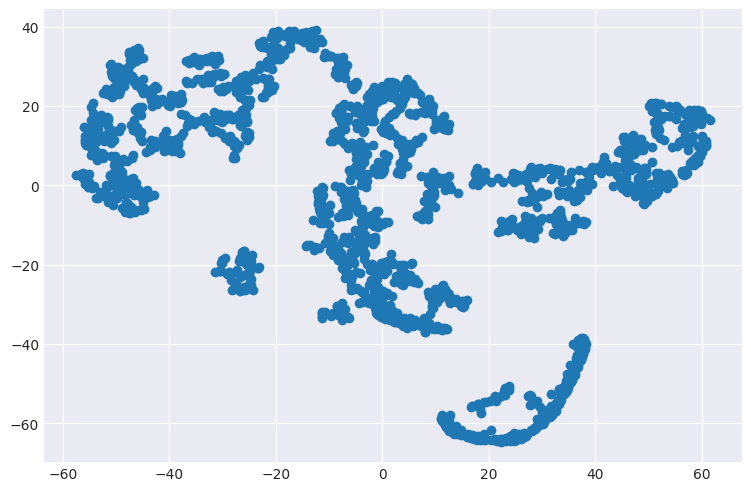

In [527]:
plt.scatter(x, y, alpha=1)
# plt.scatter(c_x, c_y, color="red")

In [528]:
x, y = zip(*dec.train_data["final"])

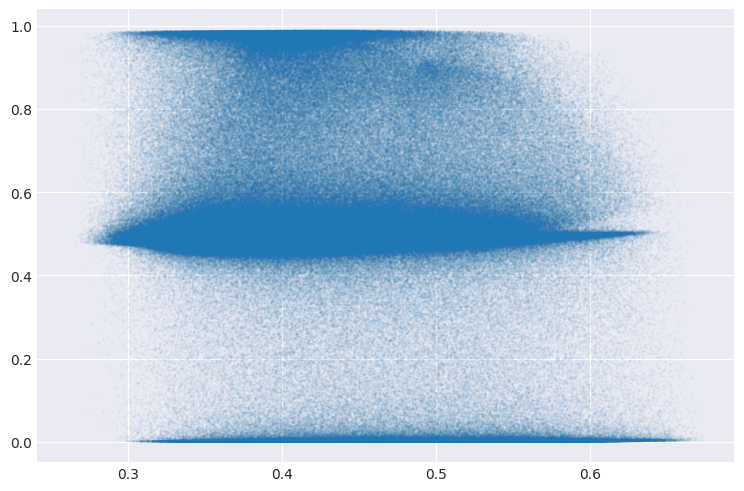

In [530]:
plt.scatter(x, y, s=0.1, alpha=0.1)

## Experiments with fake data

In [427]:
from sklearn.datasets import make_blobs, make_classification
from sklearn.cluster import MeanShift, AffinityPropagation
from sklearn.model_selection import train_test_split
from hdbscan import HDBSCAN

In [428]:
x, y = make_classification(n_samples=2560, n_features=9, n_informative=2, 
                           n_redundant=6, n_classes=3, random_state=state, n_clusters_per_class=1)

In [429]:
fake_train_x, fake_test_x, fake_train_y, fake_test_y = train_test_split(x, y, train_size=0.8, random_state=state)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [446]:
n_clusters = 3
clust = KMeans(n_clusters=n_clusters)
# clust = HDBSCAN()
params = {"train_data": fake_train_x, "test_data": fake_test_x, "SAE_code": [9, 10, 10, 5, 3, 10, 2], "denoise": False, 
          "optimizer": "nadam", "batch_size": 256, "activation": "sigmoid", "ae_loss": "mse", "n_clusters": n_clusters,
          "clusterer": clust}

In [447]:
dec_fake = DEC(**params)

In [448]:
dec_fake.init_SAE()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 10)                100       
_________________________________________________________________
dense_147 (Dense)            (None, 9)                 99        
Total params: 199.0
Trainable params: 199
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s - loss: 1.8947 - val_loss: 1.8900
Epoch 2/100
2048/2048 [==============================] - 0s - loss: 1.8660 - val_loss: 1.8602
Epoch 3/100
2048/2048 [==============================] - 0s - loss: 1.8341 - val_loss: 1.8281
Epoch 4/100
2048/2048 [==============================] - 0s - loss: 1.8007 - val_loss: 1.7956
Epoch 5/100
2048/2048 [==============================] - 0s - loss: 1.7673 - val_loss: 1.7632
Epoch 6/100
20

2048/2048 [==============================] - 0s - loss: 1.0838 - val_loss: 1.1019
Epoch 81/100
2048/2048 [==============================] - 0s - loss: 1.0824 - val_loss: 1.1005
Epoch 82/100
2048/2048 [==============================] - 0s - loss: 1.0810 - val_loss: 1.0991
Epoch 83/100
2048/2048 [==============================] - 0s - loss: 1.0797 - val_loss: 1.0978
Epoch 84/100
2048/2048 [==============================] - 0s - loss: 1.0784 - val_loss: 1.0965
Epoch 85/100
2048/2048 [==============================] - 0s - loss: 1.0771 - val_loss: 1.0952
Epoch 86/100
2048/2048 [==============================] - 0s - loss: 1.0759 - val_loss: 1.0939
Epoch 87/100
2048/2048 [==============================] - 0s - loss: 1.0747 - val_loss: 1.0927
Epoch 88/100
2048/2048 [==============================] - 0s - loss: 1.0736 - val_loss: 1.0915
Epoch 89/100
2048/2048 [==============================] - 0s - loss: 1.0724 - val_loss: 1.0904
Epoch 90/100
2048/2048 [==============================] - 0s - 

2048/2048 [==============================] - 0s - loss: 0.0239 - val_loss: 0.0244
Epoch 60/100
2048/2048 [==============================] - 0s - loss: 0.0231 - val_loss: 0.0236
Epoch 61/100
2048/2048 [==============================] - 0s - loss: 0.0224 - val_loss: 0.0228
Epoch 62/100
2048/2048 [==============================] - 0s - loss: 0.0216 - val_loss: 0.0221
Epoch 63/100
2048/2048 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0214
Epoch 64/100
2048/2048 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0208
Epoch 65/100
2048/2048 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0202
Epoch 66/100
2048/2048 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0196
Epoch 67/100
2048/2048 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0190
Epoch 68/100
2048/2048 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0185
Epoch 69/100
2048/2048 [==============================] - 0s - 

2048/2048 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0444
Epoch 39/100
2048/2048 [==============================] - 0s - loss: 0.0431 - val_loss: 0.0428
Epoch 40/100
2048/2048 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0412
Epoch 41/100
2048/2048 [==============================] - 0s - loss: 0.0400 - val_loss: 0.0398
Epoch 42/100
2048/2048 [==============================] - 0s - loss: 0.0385 - val_loss: 0.0383
Epoch 43/100
2048/2048 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0369
Epoch 44/100
2048/2048 [==============================] - 0s - loss: 0.0358 - val_loss: 0.0356
Epoch 45/100
2048/2048 [==============================] - 0s - loss: 0.0345 - val_loss: 0.0343
Epoch 46/100
2048/2048 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0330
Epoch 47/100
2048/2048 [==============================] - 0s - loss: 0.0320 - val_loss: 0.0318
Epoch 48/100
2048/2048 [==============================] - 0s - 

2048/2048 [==============================] - 0s - loss: 0.1402 - val_loss: 0.1391
Epoch 18/100
2048/2048 [==============================] - 0s - loss: 0.1395 - val_loss: 0.1385
Epoch 19/100
2048/2048 [==============================] - 0s - loss: 0.1388 - val_loss: 0.1378
Epoch 20/100
2048/2048 [==============================] - 0s - loss: 0.1382 - val_loss: 0.1372
Epoch 21/100
2048/2048 [==============================] - 0s - loss: 0.1375 - val_loss: 0.1365
Epoch 22/100
2048/2048 [==============================] - 0s - loss: 0.1368 - val_loss: 0.1359
Epoch 23/100
2048/2048 [==============================] - 0s - loss: 0.1361 - val_loss: 0.1351
Epoch 24/100
2048/2048 [==============================] - 0s - loss: 0.1353 - val_loss: 0.1344
Epoch 25/100
2048/2048 [==============================] - 0s - loss: 0.1345 - val_loss: 0.1335
Epoch 26/100
2048/2048 [==============================] - 0s - loss: 0.1336 - val_loss: 0.1327
Epoch 27/100
2048/2048 [==============================] - 0s - 

2048/2048 [==============================] - 1s - loss: 0.1110 - val_loss: 0.1080
Epoch 2/100
2048/2048 [==============================] - 0s - loss: 0.1074 - val_loss: 0.1047
Epoch 3/100
2048/2048 [==============================] - 0s - loss: 0.1043 - val_loss: 0.1021
Epoch 4/100
2048/2048 [==============================] - 0s - loss: 0.1018 - val_loss: 0.1000
Epoch 5/100
2048/2048 [==============================] - 0s - loss: 0.1000 - val_loss: 0.0984
Epoch 6/100
2048/2048 [==============================] - 0s - loss: 0.0986 - val_loss: 0.0972
Epoch 7/100
2048/2048 [==============================] - 0s - loss: 0.0974 - val_loss: 0.0961
Epoch 8/100
2048/2048 [==============================] - 0s - loss: 0.0964 - val_loss: 0.0951
Epoch 9/100
2048/2048 [==============================] - 0s - loss: 0.0954 - val_loss: 0.0942
Epoch 10/100
2048/2048 [==============================] - 0s - loss: 0.0944 - val_loss: 0.0932
Epoch 11/100
2048/2048 [==============================] - 0s - loss: 0.

2048/2048 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0034
Epoch 88/100
2048/2048 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 89/100
2048/2048 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 90/100
2048/2048 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 91/100
2048/2048 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 92/100
2048/2048 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0026
Epoch 93/100
2048/2048 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 94/100
2048/2048 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0024
Epoch 95/100
2048/2048 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0023
Epoch 96/100
2048/2048 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0022
Epoch 97/100
2048/2048 [==============================] - 0s - 

2048/2048 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0160
Epoch 67/100
2048/2048 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0158
Epoch 68/100
2048/2048 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0155
Epoch 69/100
2048/2048 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0153
Epoch 70/100
2048/2048 [==============================] - 0s - loss: 0.0149 - val_loss: 0.0151
Epoch 71/100
2048/2048 [==============================] - 0s - loss: 0.0147 - val_loss: 0.0149
Epoch 72/100
2048/2048 [==============================] - 0s - loss: 0.0145 - val_loss: 0.0147
Epoch 73/100
2048/2048 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0145
Epoch 74/100
2048/2048 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0143
Epoch 75/100
2048/2048 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0141
Epoch 76/100
2048/2048 [==============================] - 0s - 

In [449]:
dec_fake.fine_tune_SAE()

Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 2s - loss: 1.2997 - val_loss: 1.3206
Epoch 2/100
2048/2048 [==============================] - 0s - loss: 1.2866 - val_loss: 1.3078
Epoch 3/100
2048/2048 [==============================] - 0s - loss: 1.2740 - val_loss: 1.2956
Epoch 4/100
2048/2048 [==============================] - 0s - loss: 1.2627 - val_loss: 1.2848
Epoch 5/100
2048/2048 [==============================] - 0s - loss: 1.2517 - val_loss: 1.2745
Epoch 6/100
2048/2048 [==============================] - 0s - loss: 1.2417 - val_loss: 1.2646
Epoch 7/100
2048/2048 [==============================] - 0s - loss: 1.2321 - val_loss: 1.2548
Epoch 8/100
2048/2048 [==============================] - 0s - loss: 1.2226 - val_loss: 1.2452
Epoch 9/100
2048/2048 [==============================] - 0s - loss: 1.2133 - val_loss: 1.2353
Epoch 10/100
2048/2048 [==============================] - 0s - loss: 1.2037 - val_loss: 1.2253
Epoch 11/100

2048/2048 [==============================] - 0s - loss: 1.0222 - val_loss: 1.0430
Epoch 87/100
2048/2048 [==============================] - 0s - loss: 1.0220 - val_loss: 1.0428
Epoch 88/100
2048/2048 [==============================] - 0s - loss: 1.0218 - val_loss: 1.0426
Epoch 89/100
2048/2048 [==============================] - 0s - loss: 1.0216 - val_loss: 1.0424
Epoch 90/100
2048/2048 [==============================] - 0s - loss: 1.0215 - val_loss: 1.0422
Epoch 91/100
2048/2048 [==============================] - 0s - loss: 1.0213 - val_loss: 1.0420
Epoch 92/100
2048/2048 [==============================] - 0s - loss: 1.0211 - val_loss: 1.0418
Epoch 93/100
2048/2048 [==============================] - 0s - loss: 1.0209 - val_loss: 1.0417
Epoch 94/100
2048/2048 [==============================] - 0s - loss: 1.0207 - val_loss: 1.0415
Epoch 95/100
2048/2048 [==============================] - 0s - loss: 1.0205 - val_loss: 1.0413
Epoch 96/100
2048/2048 [==============================] - 0s - 

[array([[[0.19866067]],

       [[0.23308086]],

       [[0.16906953]],

       [[0.60863525]],

       [[0.39586002]],

       [[0.24522585]]], dtype=float32)]
Q shape: (256, 3)
Q shape: (256, 3)
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s - loss: 12.7648 - dense_146_loss: 6.3824 - centers_output_loss: 6.3824 - val_loss: 12.5279 - val_dense_146_loss: 6.2640 - val_centers_output_loss: 6.2640
Epoch 2/100
2048/2048 [==============================] - 0s - loss: 11.5431 - dense_146_loss: 5.7715 - centers_output_loss: 5.7715 - val_loss: 11.1428 - val_dense_146_loss: 5.5714 - val_centers_output_loss: 5.5714
Epoch 3/100
2048/2048 [==============================] - 0s - loss: 10.2023 - dense_146_loss: 5.1011 - centers_output_loss: 5.1011 - val_loss: 9.7524 - val_dense_146_loss: 4.8762 - val_centers_output_loss: 4.8762
Epoch 4/100
2048/2048 [==============================] - 0s - loss: 8.9062 - dense_146_loss: 4.4531 - centers_outpu

2048/2048 [==============================] - 0s - loss: 0.0082 - dense_146_loss: 0.0041 - centers_output_loss: 0.0041 - val_loss: 0.0074 - val_dense_146_loss: 0.0037 - val_centers_output_loss: 0.0037
Epoch 39/100
2048/2048 [==============================] - 0s - loss: 0.0078 - dense_146_loss: 0.0039 - centers_output_loss: 0.0039 - val_loss: 0.0071 - val_dense_146_loss: 0.0035 - val_centers_output_loss: 0.0035
Epoch 40/100
2048/2048 [==============================] - 0s - loss: 0.0075 - dense_146_loss: 0.0037 - centers_output_loss: 0.0037 - val_loss: 0.0068 - val_dense_146_loss: 0.0034 - val_centers_output_loss: 0.0034
Epoch 41/100
2048/2048 [==============================] - 0s - loss: 0.0072 - dense_146_loss: 0.0036 - centers_output_loss: 0.0036 - val_loss: 0.0065 - val_dense_146_loss: 0.0032 - val_centers_output_loss: 0.0032
Epoch 42/100
2048/2048 [==============================] - 0s - loss: 0.0069 - dense_146_loss: 0.0035 - centers_output_loss: 0.0035 - val_loss: 0.0062 - val_dense

2048/2048 [==============================] - 0s - loss: 0.0025 - dense_146_loss: 0.0013 - centers_output_loss: 0.0013 - val_loss: 0.0023 - val_dense_146_loss: 0.0012 - val_centers_output_loss: 0.0012
Epoch 77/100
2048/2048 [==============================] - 0s - loss: 0.0024 - dense_146_loss: 0.0012 - centers_output_loss: 0.0012 - val_loss: 0.0023 - val_dense_146_loss: 0.0011 - val_centers_output_loss: 0.0011
Epoch 78/100
2048/2048 [==============================] - 0s - loss: 0.0024 - dense_146_loss: 0.0012 - centers_output_loss: 0.0012 - val_loss: 0.0022 - val_dense_146_loss: 0.0011 - val_centers_output_loss: 0.0011
Epoch 79/100
2048/2048 [==============================] - 0s - loss: 0.0023 - dense_146_loss: 0.0012 - centers_output_loss: 0.0012 - val_loss: 0.0022 - val_dense_146_loss: 0.0011 - val_centers_output_loss: 0.0011
Epoch 80/100
2048/2048 [==============================] - 0s - loss: 0.0023 - dense_146_loss: 0.0011 - centers_output_loss: 0.0011 - val_loss: 0.0021 - val_dense

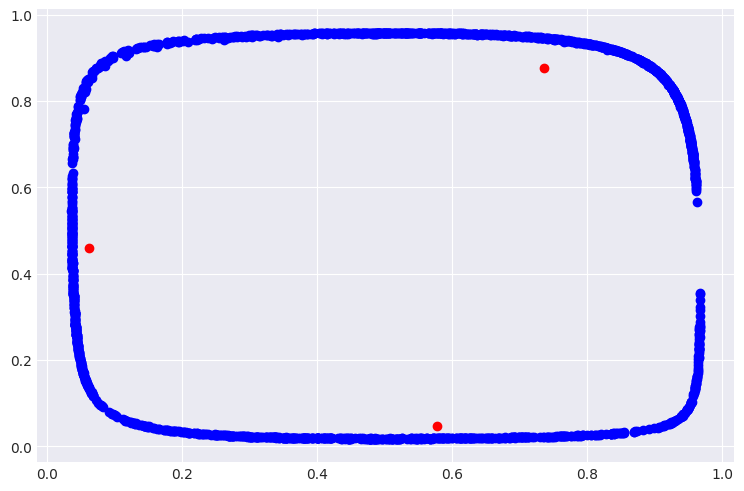

In [450]:
dec_fake.learn_clustering()

In [451]:
x, y = zip(*dec_fake.optimized_encoded[0])

In [452]:
centers = np.reshape(dec_fake.optimized_centers[0], (n_clusters, 2))
c_x, c_y = zip(*centers)

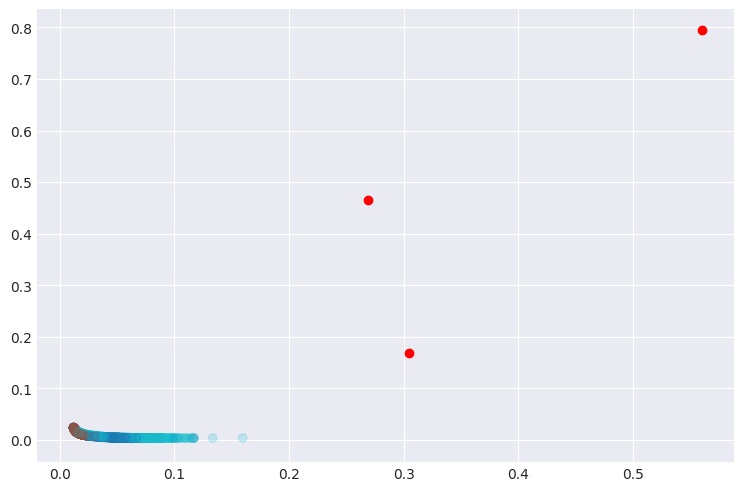

In [455]:
plt.scatter(x, y, c=fake_train_y, cmap="tab10", alpha=0.2)

In [260]:
# x, y = zip(*dec_fake.train_data["final"])

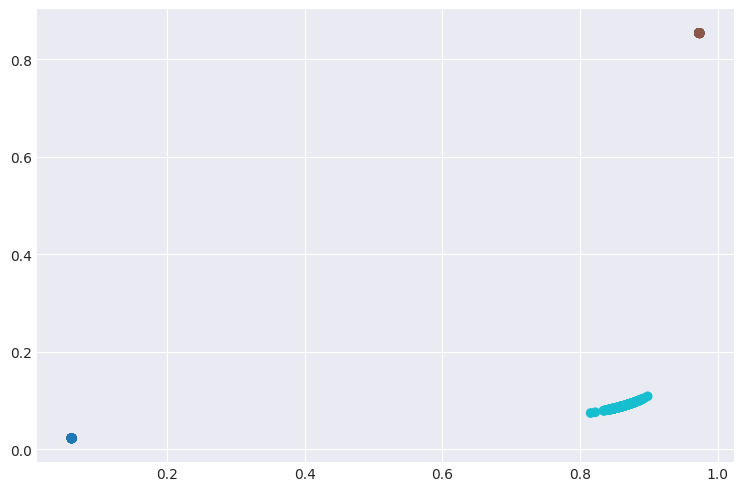

In [262]:
plt.scatter(x, y, c=fake_train_y, cmap="tab10")

In [206]:
kek = np.random.rand(1000, 10)
k = KMeans()
k.fit(kek)
weights = k.cluster_centers_
batch_size = 10

In [207]:
lol_data = np.array([np.ones(shape=weights.shape) for _ in range(batch_size)])
lol_data = np.reshape(lol_data, (*lol_data.shape, 1))

In [141]:
pointwise = LocallyConnected2D(1, kernel_size=(1, 1), use_bias=False, 
                               input_shape=(*weights.shape, 1))

In [142]:
lol_data.shape[0], 1, lol_data.shape[1], lol_data.shape[2]

(10, 1, 8, 10)

In [125]:
weights.shape

(8, 10)

In [126]:
lol_weights = np.array([weights for _ in range(batch_size)])

In [148]:
model = Sequential()
model.add(pointwise)
pointwise.set_weights(np.reshape(weights, (1, 80, 1, 1)))

In [151]:
out = model.predict(lol_data)

In [153]:
out.shape

(10, 8, 10, 1)

In [154]:
norm_out = np.reshape(out, (out.shape[0], out.shape[1], out.shape[2]))

In [145]:
ril_w = np.array(pointwise.get_weights())

In [146]:
ril_w.shape

(1, 80, 1, 1)

In [16]:
kek = np.ones(shape=(2, 3))

In [19]:
kek[1, 0] = 3
kek[0, 0] = 2.5
kek[0, 2] = 1.8
kek[1, 2] = 5

In [22]:
kek

array([[2.5, 1. , 1.8],
       [3. , 1. , 5. ]])

In [36]:
kek_lol = np.zeros_like(kek)
for i, _ in enumerate(kek):
    kek_lol += np.roll(kek, i, axis=0)
    

In [32]:
np.roll?

In [35]:
kek

array([[2.5, 1. , 1.8],
       [3. , 1. , 5. ]])

In [37]:
kek_lol

array([[5.5, 2. , 6.8],
       [5.5, 2. , 6.8]])

In [24]:
kek ** 3 / kek

array([[ 6.25,  1.  ,  3.24],
       [ 9.  ,  1.  , 25.  ]])

## Test SAE

In [148]:
params = {"train_data": x_train.values, "test_data": x_test.values, "SAE_code": "65432", "denoise": False, 
          "optimizer": "nadam", "batch_size": 256, "activation": "sigmoid", "ae_loss": "mse"}

In [149]:
dec = DEC(**params)

In [150]:
dec.init_SAE()

Train on 1765185 samples, validate on 441297 samples
Epoch 1/20
1765185/1765185 [==============================] - 10s - loss: 0.0176 - val_loss: 0.0081
Epoch 2/20
1765185/1765185 [==============================] - 10s - loss: 0.0078 - val_loss: 0.0076
Epoch 3/20
1765185/1765185 [==============================] - 10s - loss: 0.0076 - val_loss: 0.0075
Epoch 4/20
1765185/1765185 [==============================] - 10s - loss: 0.0075 - val_loss: 0.0074
Epoch 5/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 6/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 7/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 8/20
1765185/1765185 [==============================] - 11s - loss: 0.0074 - val_loss: 0.0074
Epoch 9/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0073
Epoch 10/20
1765185/1765185 [==================

In [151]:
dec.fine_tune_SAE()

Train on 1765185 samples, validate on 441297 samples
Epoch 1/100
1765185/1765185 [==============================] - 13s - loss: 0.0392 - val_loss: 0.0385
Epoch 2/100
1765185/1765185 [==============================] - 13s - loss: 0.0384 - val_loss: 0.0383
Epoch 3/100
1765185/1765185 [==============================] - 13s - loss: 0.0383 - val_loss: 0.0381
Epoch 4/100
1765185/1765185 [==============================] - 13s - loss: 0.0377 - val_loss: 0.0369
Epoch 5/100
1765185/1765185 [==============================] - 13s - loss: 0.0360 - val_loss: 0.0350
Epoch 6/100
1765185/1765185 [==============================] - 13s - loss: 0.0341 - val_loss: 0.0334
Epoch 7/100
1765185/1765185 [==============================] - 14s - loss: 0.0329 - val_loss: 0.0324
Epoch 8/100
1765185/1765185 [==============================] - 13s - loss: 0.0321 - val_loss: 0.0318
Epoch 9/100
1765185/1765185 [==============================] - 13s - loss: 0.0316 - val_loss: 0.0315
Epoch 10/100
1765185/1765185 [========

In [ ]:
dec.train_data["final"]

In [152]:
x, y = zip(*dec.train_data["final"])

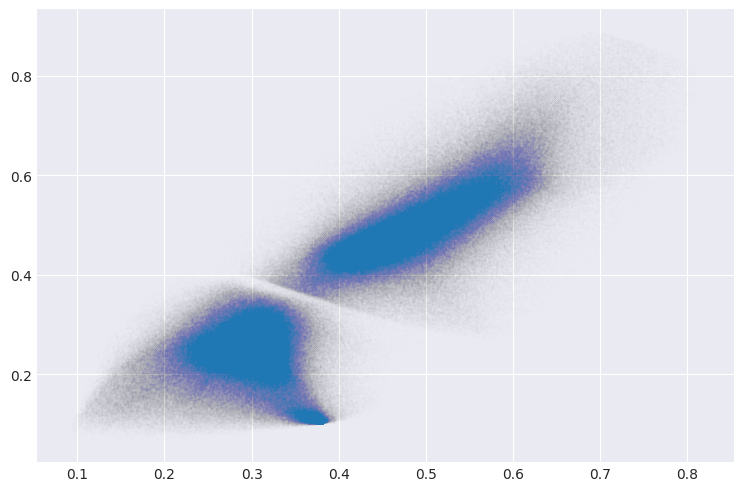

In [157]:
plt.scatter(x, y, alpha=0.006, s=0.1)

## Let's try HDBSCAN (fuck it), Affinity propagation (fuck it) and Mean shift (this one is ok)

In [165]:
from hdbscan import HDBSCAN
from collections import Counter

In [192]:
from sklearn.cluster import MeanShift, AffinityPropagation
from sklearn.manifold import TSNE

In [159]:
hdb = HDBSCAN()

In [187]:
aff = AffinityPropagation()

In [170]:
ms = MeanShift()

In [199]:
lil_shit_ind = np.random.choice(np.array(range(len(dec.train_data["final"]))), 3000)
lil_shit = dec.train_data["final"][lil_shit_ind]

In [160]:
labels = hdb.fit_predict(dec.train_data["final"])

What the fuck were that labels???

In [185]:
ms_labels=ms.fit_predict(lil_shit)

In [190]:
aff_labels=aff.fit_predict(lil_shit)

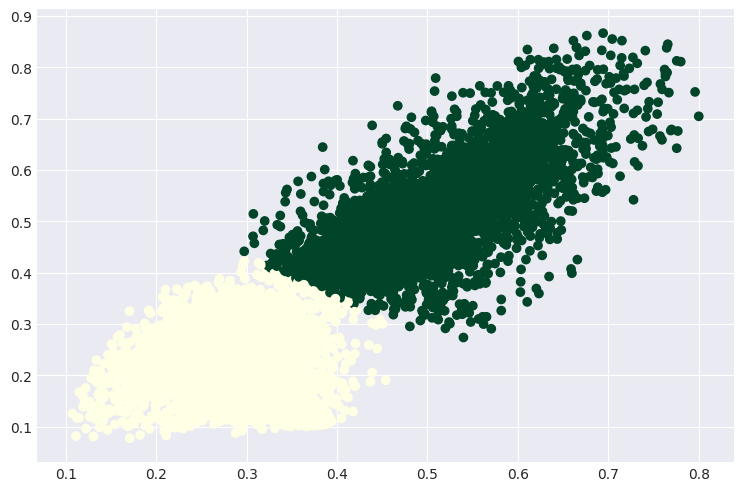

In [186]:
plt.scatter(*zip(*lil_shit), c=ms_labels, cmap="YlGn")

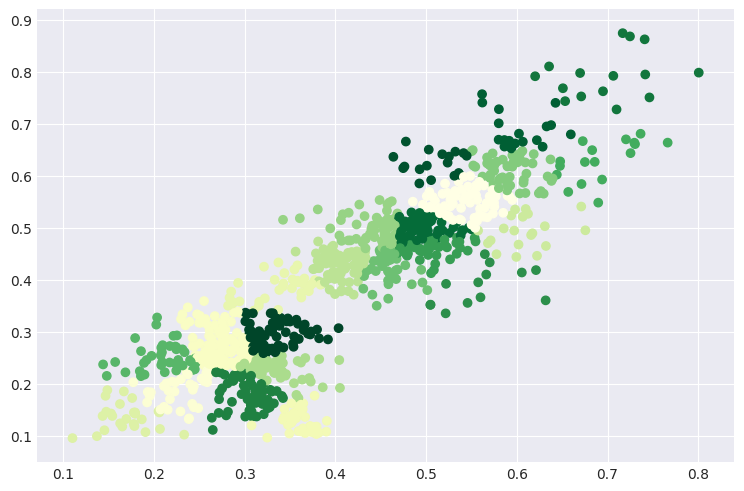

In [191]:
plt.scatter(*zip(*lil_shit), c=aff_labels, cmap="YlGn")

In [200]:
tsne = TSNE()

In [201]:
tsne_table = tsne.fit_transform(lil_shit)

In [203]:
x, y = zip(*tsne_table)

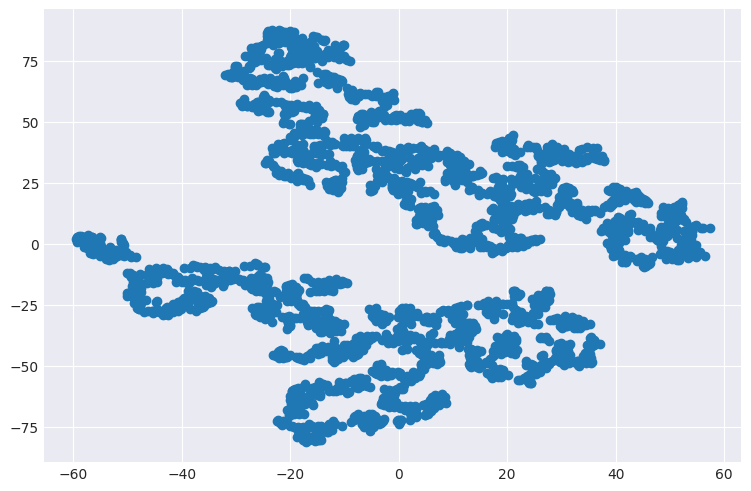

In [204]:
plt.scatter(x, y)

In [166]:
counter = Counter(labels)

In [168]:
counter.most_common(10)

[(-1, 772237),
 (25624, 347),
 (26616, 303),
 (56053, 282),
 (17694, 234),
 (30710, 216),
 (52841, 203),
 (26042, 202),
 (26665, 188),
 (26509, 186)]